In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json, random, pickle, h5py
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [3]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 22

In [3]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [4]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [5]:
pick_frame_every_no = max_frame / 50 + 1

In [6]:
x = np.zeros([data_length, timesteps, dimensions])
y = np.zeros([data_length])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[2 * ((word_no * data_per_word) + data_no), curr_idx, :] = feature
            curr_idx += 1

        y[2 * ((word_no * data_per_word) + data_no)] = word_no
#         print((word_no * data_per_word * 2) + data_no)
        del_idx = range(0, len(json_data), pick_frame_every_no)
        json_data_speedup = np.delete(json_data, del_idx)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data_speedup):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[(word_no * data_per_word * 2) + data_per_word + data_no, curr_idx, :] = feature
            curr_idx += 1

        y[(word_no * data_per_word * 2) + data_per_word + data_no] = word_no
#         print((word_no * data_per_word * 2) + 1 + data_no)
#         print('___')

In [4]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

NameError: name 'x' is not defined

In [5]:
x_train = np.zeros([data_length * 4 / 6, timesteps, dimensions])
y_train = np.zeros([data_length * 4 / 6])
x_test = np.zeros([data_length / 6, timesteps, dimensions])
y_test = np.zeros([data_length / 6])
x_valid = np.zeros([data_length / 6, timesteps, dimensions])
y_valid = np.zeros([data_length / 6])
train_count = test_count = valid_count = 0

for idx in range(data_length):
    if idx % 6 == 0:
        test_idx = random.sample(xrange(6), 1)
        valid_idx = random.sample(xrange(6), 1)
        while valid_idx == test_idx:
            valid_idx = random.sample(xrange(6), 1)
#         print('rand', test_idx, valid_idx)
    if idx % 6 == test_idx[0]:
#         print('test', test_count, idx)
        x_test[test_count] = x_norm[idx]
        y_test[test_count] = y[idx]
        test_count += 1
    elif idx % 6 == valid_idx[0]:
#         print('valid', valid_count, idx)
        x_valid[valid_count] = x_norm[idx]
        y_valid[valid_count] = y[idx]
        valid_count += 1
    else:
#         print('train', train_count, idx)
        x_train[train_count] = x_norm[idx]
        y_train[train_count] = y[idx]
        train_count += 1

TypeError: 'float' object cannot be interpreted as an integer

In [9]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 4 / 6, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 4 / 6])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [10]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))
Y_valid = np_utils.to_categorical(y_valid, len(words))

In [11]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [1]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_valid, Y_valid), epochs=2000, batch_size=8, shuffle=True)
# model.save_weights("model_weight.h5")
model.save("./history/model213182331.h5")
with open('./history/history213182331.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

NameError: name 'model' is not defined

In [24]:
model = load_model("./history/model213182331.h5")
with open('./history/history213182331.pkl', 'rb') as handle:
    load_history = pickle.load(handle)

In [13]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

171/171 [==============================] - 0s 645us/step
('Test score:', 0.43841621549854504)
('Test accuracy:', 0.8596491245498434)


In [14]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


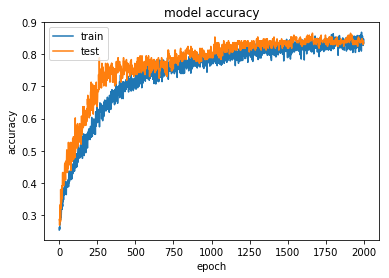

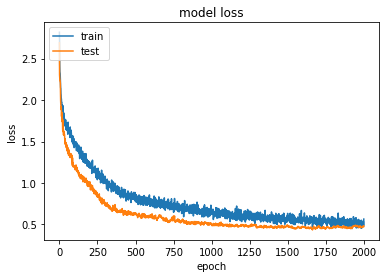

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()